In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

import sys
import os
dir_current = globals()['_dh'][0]
dir_repo = dir_current+'/../..'
dir_BinnedFit = dir_repo+"/BinnedFit"
dir_KLens = dir_repo+"/KLens"
dir_TNGcube = dir_repo+"/TNGcube"

sys.path.append(dir_KLens)
from KLtool import *

sys.path.append(dir_TNGcube)
from TNGcube import *

sys.path.append(dir_BinnedFit)
from binnedFit_utilities import lambda_to_velocity, velocity_to_lambda

Populating the interactive namespace from numpy and matplotlib


In [2]:
subhalo = pickle.load(open('../notebooks/subhalo_35.pkl', 'rb'))

In [3]:
pars = {}
pars['spinR'] = [0, 0, -1]
pars['sini'] = 1.
pars['theta_int'] = 0. #np.pi/6.
pars['g1'] = 0.
pars['g2'] = 0.
pars['redshift'] = 0.3
pars['psfFWHM'] = 0.5
pars['sigma_thermal'] = 16.  # [unit: km/s]

pars['slitAngles'] = [0., np.pi/2]

lambda_cen0 = ParametersTNG.lineLambda0['Halpha']
#lambda_cen0 = (lineLambda0['OIIa']+lineLambda0['OIIb'])/2.

pars['lambda_cen'] = (1+pars['redshift'])*lambda_cen0

In [4]:
pars['expTime'] = 30.*60.              # [unit: sec]
pars['area'] = 3.14 * (1000./2.)**2    # telescope area [unit: cm2]

pars['ref_SDSS_lineL'] = 3.*1e-17      # [unit: erg/s/Angstrom/cm2]    # * u.erg/u.second/u.Angstrom/u.cm**2

fiber_SDSS = np.pi * 1.5**2.           # fiber size [unit: arcsec2]
refSDSSspec = pars['ref_SDSS_lineL'] * u.erg/u.second/u.Angstrom/u.cm**2
refSDSSspec = refSDSSspec.to(u.erg/u.second/u.nm/u.cm**2)
print('reference SDSS fiber spec:', refSDSSspec)

pars['lineflux'] = refSDSSspec.value / fiber_SDSS  # [unit: erg/s/cm2/nm/arcsec2]
pars['lineflux']

pars['ngrid'] = 256

reference SDSS fiber spec: 2.9999999999999994e-16 erg / (cm2 nm s)


In [5]:
mock = TNGmock(pars=pars, subhalo=subhalo, auto_tune=True)

residual PA = 5.282 deg. (auto-corrected)
residual center offset: (-0.040, 0.035) [arcsec] (auto-corrected)
residual center offset: (-0.162, 0.142) [ckpc] (auto-corrected)


/Users/hhg/Research/kinematic_lensing/repo/TNGcube/notebooks/../../TNGcube/TNGcube.py:784: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 324x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd7c86b0350>)

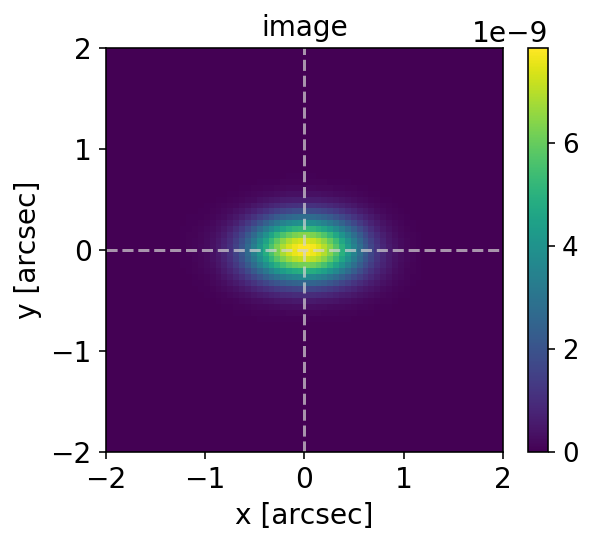

In [6]:
image0 = mock.gen_mock_image(weights='line', noise_mode=0)
image0.display(xlim=[-2,2])

In [7]:
from imageFit import ImageFit
from tfCube2 import Parameters
from chainTool import ChainTool

par_init = Parameters(pars).fid
imgFit = ImageFit(image0, par_init=par_init)

In [8]:
chainImage_info = imgFit.run_MCMC(Nwalker=50, Nsteps=1000, active_par_key=['e_obs', 'r_hl_image', 'theta_int', 'flux'], par_fix={'g1':0., 'g2':0.})

100%|██████████| 1000/1000 [2:58:19<00:00, 10.70s/it]  

Total MCMC time (mins): 178.32854920228323


In [9]:
Chain_Image = ChainTool(chainImage_info, Nburn=25000, Nend=50000)

In [10]:
from chainconsumer import ChainConsumer

blue        = "#214F94"
red         = "#CC0204"
yellow      = "#FFA903"
gray        = "#858278"
black       = "#000000"
green       = "#73ab24"
purple      = "#8600C8"
lightblue   = "#6898FF"
lightblue2  = "#82b9e6"
yellowgreen = "#8dcd32" #"#8DE900"
lightteal   = "#7FC2BF"
teal        = "#51ABAE"
lightgray   = "#CDCDCD"

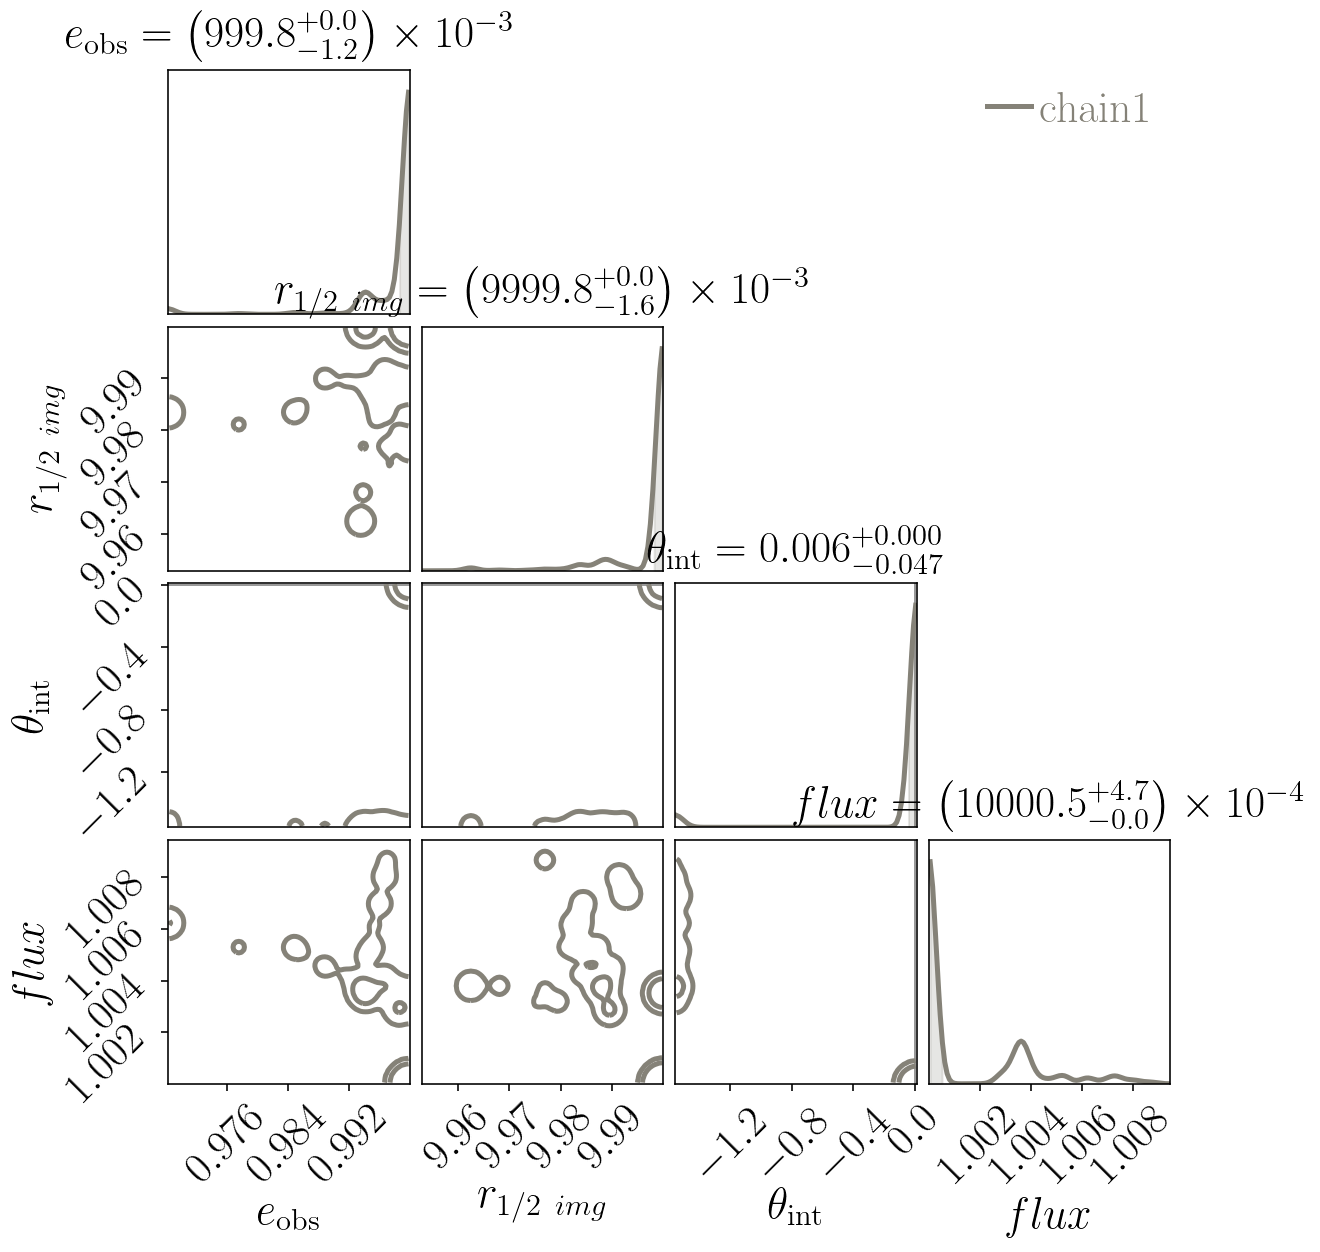

In [11]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['e_obs','r_hl_image','theta_int','flux']

parID1,parName1,par_x1 = Chain_Image.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain_Image.chain[:, parID1], parameters=parName1 ,name="$\mathrm{chain1}$")


c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=22,tick_font_size=22
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=True
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains)


c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
truth_pt = [Chain_Image.par_fid[item] for item in imgFit.active_par_key]
fig = c.plotter.plot(legend=True, truth=truth_pt) #, truth=par_x1

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2 + fig.get_size_inches())
fig.savefig("fig1.pdf", transparent=True)

In [12]:
Chain_Image.par_bestfit(select_par_key=['theta_int'], statistics='max', mode=0)

{'theta_int': [-0.015788256019689362,
  0.01016931199204471,
  0.01016931199204471]}